1. Завантаження даних та поділ на тренувальний, валідаційний і тестовий набори


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# Завантаження даних MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Перетворення міток у цілі числа
y = y.astype(np.uint8)

# Поділ на тренувальний (50k), валідаційний (10k) і тестовий (10k) набори
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_valid.shape, X_test.shape


((56000, 784), (7000, 784), (7000, 784))

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Завантажуємо MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

# Перетворюємо на DataFrame
df = mnist.frame

# Виводимо перші 5 рядків
df.head()


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


2. Навчання моделей: Random Forest, Extra-Trees, SVM


In [3]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# Ініціалізація моделей
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,max_depth=10)
et_clf = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
svm_clf = SVC(probability=True, random_state=42)  # Важливо для soft voting

# Навчання моделей
rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)


SVC(probability=True, random_state=42)

3. Оцінка точності моделей на валідаційному наборі


In [4]:
print("Random Forest accuracy:", rf_clf.score(X_valid, y_valid))
print("Extra-Trees accuracy:", et_clf.score(X_valid, y_valid))
print("SVM accuracy:", svm_clf.score(X_valid, y_valid))

Random Forest accuracy: 0.9391428571428572
Extra-Trees accuracy: 0.9645714285714285
SVM accuracy: 0.975


4. Ансамбль (жорстке голосування)


In [5]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('et', et_clf), ('svm', svm_clf)],
    voting='hard'
)

# Навчання ансамблю
voting_clf.fit(X_train, y_train)

# Оцінка точності
print("Voting Classifier (hard) accuracy:", voting_clf.score(X_valid, y_valid))


Voting Classifier (hard) accuracy: 0.9651428571428572


5. Видалення SVM та перевірка продуктивності


In [7]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

# Створюємо класифікатори
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Створюємо VotingClassifier без SVM
voting_clf_new = VotingClassifier(
    estimators=[('rf', rf_clf), ('extra', extra_clf)],  # Тут додаємо тільки RandomForest і ExtraTrees
    voting="hard"
)

# Навчаємо ансамбль
voting_clf_new.fit(X_train, y_train)

# Оцінюємо точність
print("Voting Classifier (без SVM) accuracy:", voting_clf_new.score(X_valid, y_valid))


Voting Classifier (без SVM) accuracy: 0.9655714285714285


6. Soft Voting


In [8]:
voting_clf.voting = 'soft'
print("Voting Classifier (soft) accuracy:", voting_clf.score(X_valid, y_valid))


Voting Classifier (soft) accuracy: 0.9582857142857143


7. Оцінка на тестовому наборі


In [9]:
print("Final Voting Classifier accuracy on test set:", voting_clf.score(X_test, y_test))


Final Voting Classifier accuracy on test set: 0.9637142857142857


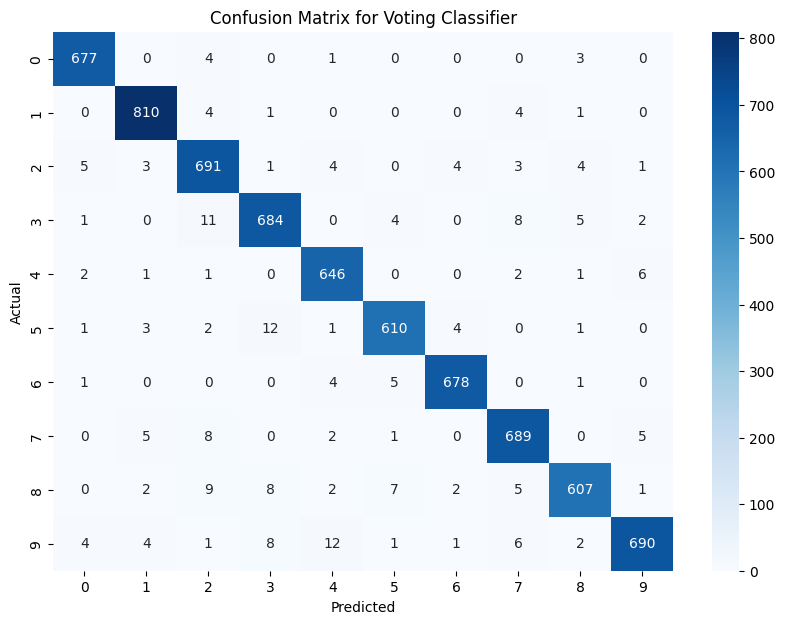

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Отримуємо передбачення на тестовому наборі
y_pred = voting_clf_new.predict(X_test)

# Створюємо матрицю невідповідностей
cm = confusion_matrix(y_test, y_pred)

# Візуалізуємо
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Voting Classifier")
plt.show()


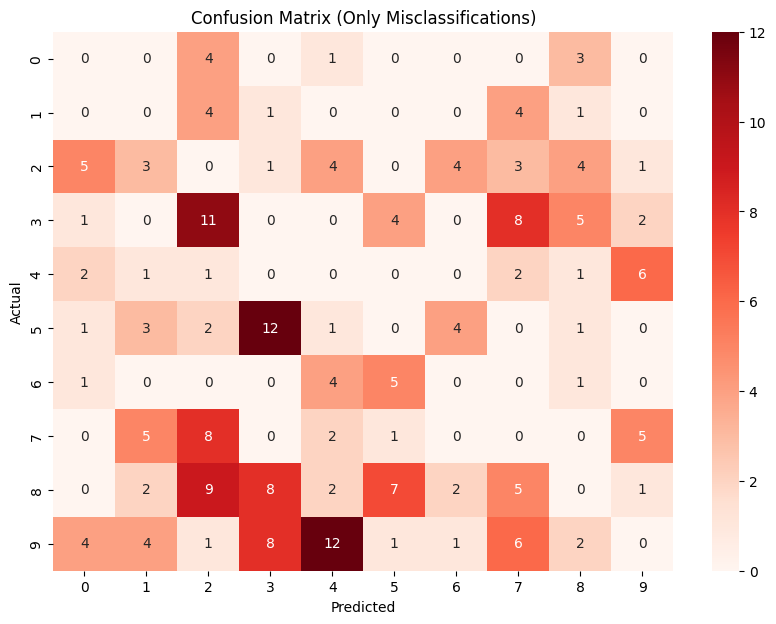

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Отримуємо передбачення на тестовому наборі
y_pred = voting_clf_new.predict(X_test)

# Створюємо матрицю невідповідностей
cm = confusion_matrix(y_test, y_pred)

# Обнуляємо правильні передбачення (по діагоналі)
np.fill_diagonal(cm, 0)

# Візуалізуємо тільки невірні передбачення
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Only Misclassifications)")
plt.show()


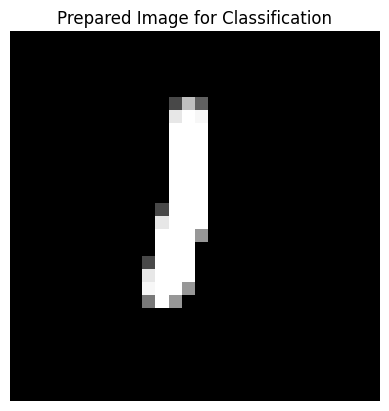

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Завантажуємо зображення (шлях до твого файлу)
img = cv2.imread("1.png", cv2.IMREAD_GRAYSCALE)

# Змінюємо розмір до 28x28, оскільки MNIST працює з таким розміром
img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

# Перетворюємо значення пікселів у діапазон 0–255 (якщо були нормалізовані)
img_resized = img_resized.astype(np.uint8)

# Перетворюємо в тензор (1, 784) для sklearn
img_flatten = img_resized.reshape(1, -1)

# Візуалізуємо підготовлене зображення
plt.imshow(img_resized, cmap="gray")
plt.title("Prepared Image for Classification")
plt.axis("off")
plt.show()


In [53]:
prediction = voting_clf.predict(img_flatten)
print(f"Модель вважає, що це: {prediction[0]}")


Модель вважає, що це: 1


In [55]:
print(img_flatten)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  72 191  96   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  231 255 247   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255 255 255   0   0   0   0 

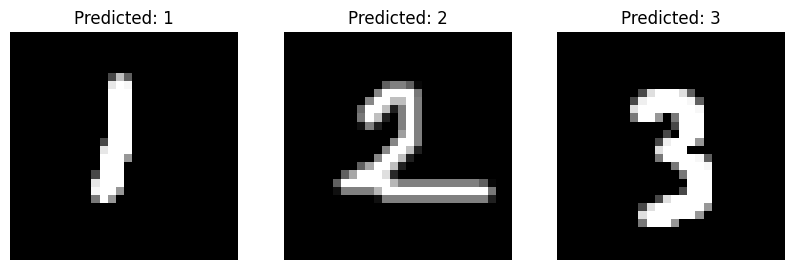

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Функція для підготовки зображення
def prepare_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    img_resized = img_resized.astype(np.uint8)  # Переконуємося, що значення від 0 до 255
    img_flatten = img_resized.reshape(1, -1)  # Перетворюємо в (1, 784)
    return img_flatten, img_resized

# Завантажуємо три зображення
image_paths = ["1.png", "2.png", "3.png"]  # Замініть на свої файли
samples = []
visuals = []

for path in image_paths:
    img_flatten, img_resized = prepare_image(path)
    samples.append(img_flatten)
    visuals.append(img_resized)

# Перетворюємо список у numpy-масив для передачі в модель
X_sample = np.vstack(samples)  # (3, 784)

# Передаємо в навчений класифікатор
predictions = voting_clf.predict(X_sample)  # Переконайся, що voting_clf вже навчений

# Візуалізуємо зображення та їх передбачення
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, ax in enumerate(axes):
    ax.imshow(visuals[i], cmap="gray")
    ax.set_title(f"Predicted: {predictions[i]}")
    ax.axis("off")

plt.show()